To obtain and preprocess the data for the segmentation task
The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />
You can directly download the full body cts and segmentation maps from: <br />
https://drive.google.com/file/d/1I1LR7XjyEZ-VBQ-Xruh31V7xExMjlVvi/view?usp=sharing


In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2


## Looking at the data

In [2]:
root = Path("D:/chrome_downloads/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/Solution/Task06_Lung/imagesTr/")
label = Path("D:/chrome_downloads/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/Solution/Task06_Lung/labelsTr/")

In [8]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [9]:
sample_path = list(root.glob("lung*"))[2]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [10]:
sample_path, sample_path_label

(WindowsPath('D:/chrome_downloads/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/Solution/Task06_Lung/imagesTr/lung_004.nii.gz'),
 WindowsPath('D:/chrome_downloads/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation/Solution/Task06_Lung/labelsTr/lung_004.nii.gz'))

Load NIfTI and extract image data

In [11]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [12]:
nib.aff2axcodes(data.affine) # Left aanterior side

('L', 'A', 'S')

<IPython.core.display.Javascript object>


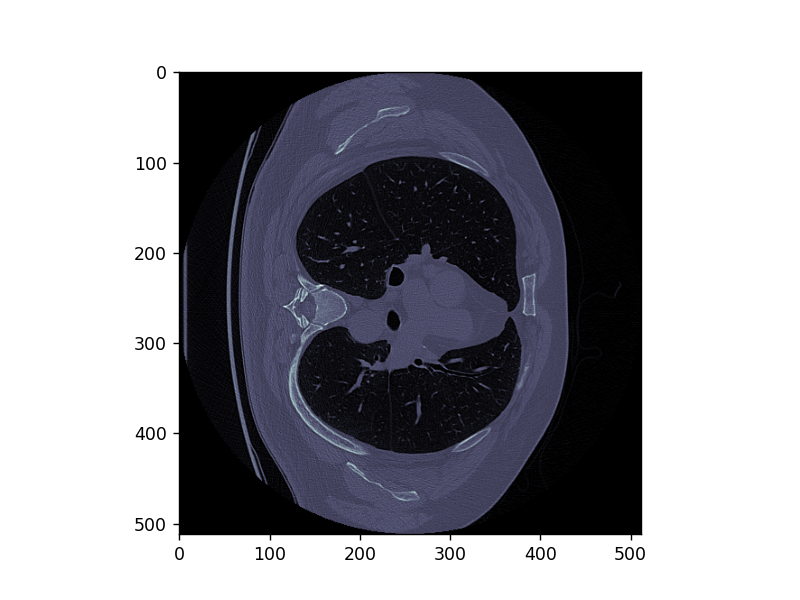

In [13]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




## Preprocessing
To preprocess our CT images and prepare them for training, we need to perform the following steps:

Normalize the pixel values of the CT images by dividing them by 3071, as the pixel values in CT images have a fixed range from -1000 to 3071.
Crop the lower abdomen from the CT images to reduce complexity and focus on lung tumors. To do this, we can skip the first 30 slices from the last axis.
Store the preprocessed CT images and their corresponding labels as 2D files instead of 3D files, as we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce computational cost.
Resize the CT images and their corresponding labels to (256, 256) size. When resizing the labels, apply nearest neighbour interpolation by passing the argument "interpolation=cv2.INTER_NEAREST" to the resize function.
Ensure that all scans have the same orientation.
To implement these steps, we can loop over all the files in our dataset and apply the preprocessing steps to each file. We should create a directory for each subject containing the preprocessed CT and label slices with identical names.

We should store the preprocessed data for the last 6 subjects as validation data. Here's an example of how we can structure our directories:

Subject0/data/0.npy
Subject0/masks/0.npy
Subject1/data/0.npy
Subject1/masks/0.npy
...
SubjectLast-6/data/0.npy
SubjectLast-6/masks/0.npy
By following these steps, we can preprocess our CT images and prepare them for training a tumor detection model.

In [15]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [16]:
len(all_files)

63

In [ ]:
save_root = Path("Task06_Lung/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label. Remove the first 30 slices  
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

## Validate preprocessed data


In [3]:
path = Path("Task06_Lung/Preprocessed/train/2")  # Select a subject. Check the folder if it exists


In [4]:
list(path.glob("*"))

[WindowsPath('Task06_Lung/Preprocessed/train/2/data'),
 WindowsPath('Task06_Lung/Preprocessed/train/2/masks')]

In [5]:
1# Choose a file and load slice + mask
file = "120.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


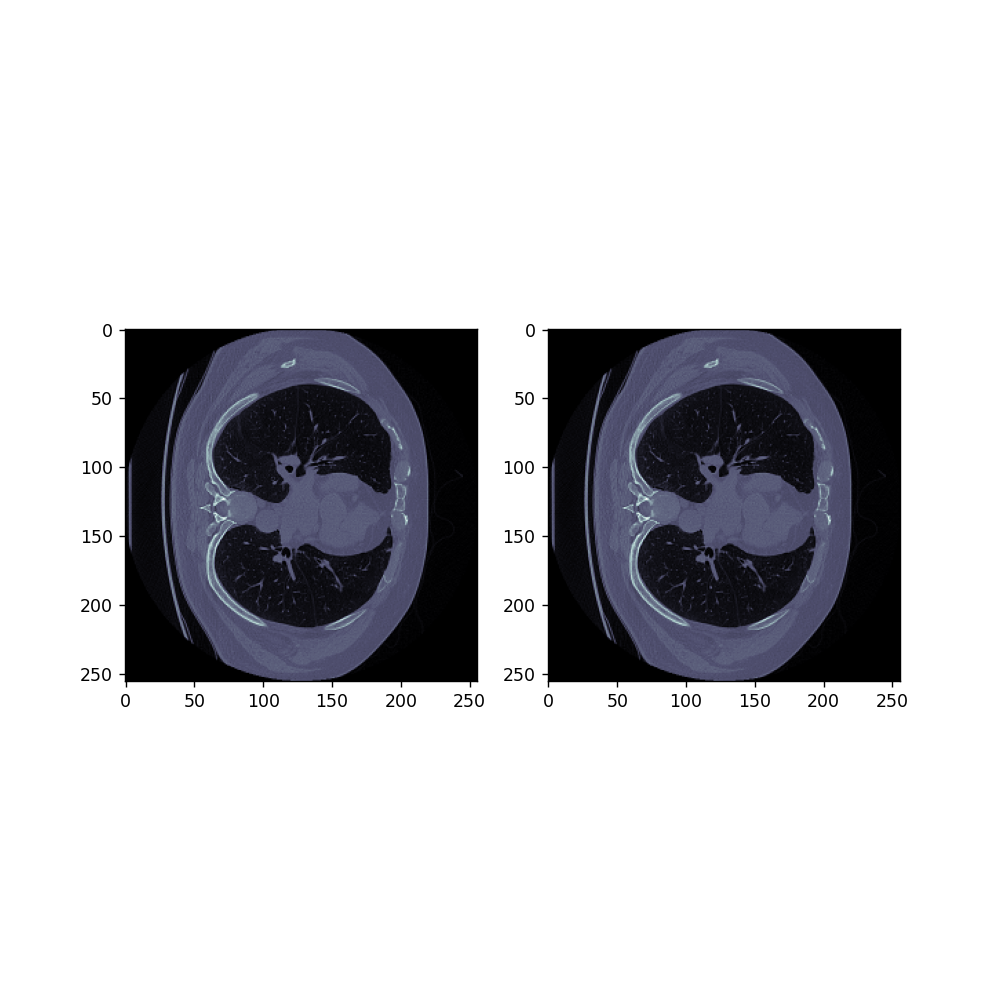

In [6]:
# Plot everything
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [22]:
print(slice.min(), slice.max())

-0.33344187561055033 0.5271898404428524
